# SHAP(SHapley Additive exPlanations)

- 로이드 섀플리가 만든 이론 위에 피처 간 독립성을 근거로 덧셈이 가능하게 활용도를 넓힌 논문
- 섀플리 값 : 전체 성과를 창출하는 데 각 참여자가 얼마나 공헌했는지를 수치로 표현 -> 각 사람의 기여도는 그 사람의 기여도를 제외했을 때 전체성과의 변화 정도로 나타낼 수 있음

- Feature Importances : 타겟 값을 예측하는 피처들 몇 개가 서로 의존적이라면 피처 영향력이 잘못 계산될 우려
- PDP : 특정 피처가 변할 때 타겟 값에 어떤 영향을 미치는지 시각화 가능. 그러나 3차원까지의 관계만 표시할 수 있다는 한계가 있다.
- SHAP : 타겟 값 결정 기준이 어떻게 배분되는지 균형 있게 해석. 그러나 시간이 오래 걸리고 이상치에 대해 허술한 해석 내놓을 가능성이 높다.
- 1,2는 모델 관점에 대한 설명, 3은 데이터 하나에 대한 설명을 구한다는 차이


In [3]:
import shap
from sklearn.model_selection import train_test_split

In [4]:
X,y = shap.datasets.boston()

X.columns =[col.lower() for col in X.columns]

In [ ]:
X_tr,X_val,y_tr,y_val = train_test_split(X,y,test_size=0.2,random_state=42)

In [15]:
from sklearn.linear_model import LinearRegression

import pandas as pd

In [21]:
lr = LinearRegression()

lr.fit(X=pd.DataFrame(X_tr['rm']),y = y_tr)

predict = lr.predict(X =pd.DataFrame(X_val['rm']))

In [22]:
print(f"a Value : {lr.intercept_}")
print(f"b Value : {lr.coef_}")

a Value : -36.24631889813792
b Value : [9.34830141]


In [23]:
df = X.copy()

In [25]:
df['y'] = y

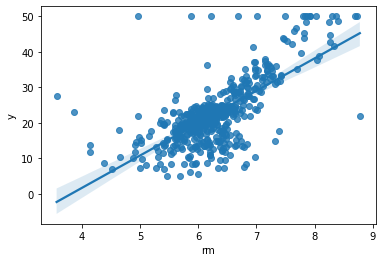

In [27]:
sns.regplot(x='rm',y = 'y',data=df)

In [29]:
from sklearn.metrics import mean_squared_error
import numpy as np

In [32]:
rmse =  np.sqrt(mean_squared_error(y_val,predict))
print(f"RMSE : {rmse}")

RMSE : 6.792994578778734


In [34]:
from xgboost import XGBRegressor

In [35]:
xgb = XGBRegressor(objective='reg:linear')

In [36]:
xgb.fit(X_tr,y_tr)

[17:11:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [37]:
pred = xgb.predict(X_val)

In [38]:
rmse2 = np.sqrt(mean_squared_error(y_val,pred))

print(f"RMSE : {rmse2}")

RMSE : 2.6956868958363156


In [39]:
shap.initjs()

explainer = shap.TreeExplainer(xgb)

shap_values = explainer.shap_values(X_tr)

In [42]:
shap.force_plot(explainer.expected_value,
               shap_values[0,:],
               X_tr.iloc[0,:])

- 집값 하락에 부정적인 가장 요소는 lstat(동네의 하위 계층 비율)이다.
- 집값 상승에 가장 긍정적인 요소는 crim(도시 구역당 범죄 비율)이다.

In [43]:
shap.force_plot(explainer.expected_value,
               shap_values[259,:],
               X_tr.iloc[259,:])

**259번이 집값이 높은 이유**

- age,lsat,dist 순으로 긍정적인 영향을 미친다

In [44]:
shap.force_plot(explainer.expected_value,shap_values,X_tr)

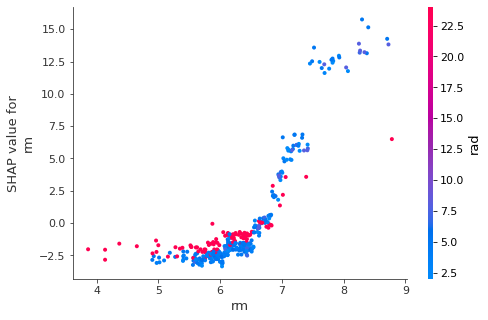

In [45]:
shap.dependence_plot('rm',shap_values,X_tr)

- 피처 하나(rm)에 대한 SHAP 영향력을 보여줌

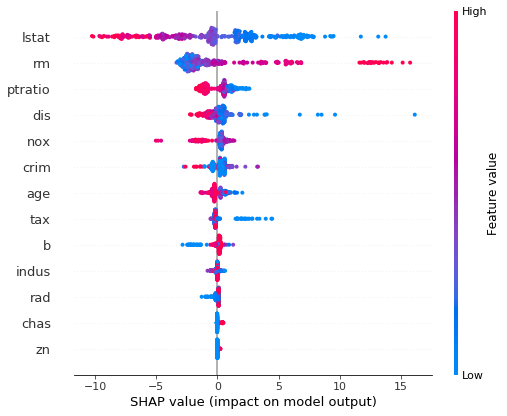

In [46]:
shap.summary_plot(shap_values,X_tr)

- 붉은색 점 : 그 지점에 해당하는 행 피처가 집값을 결정하는데 큰 영향
- 파란색 점 : 행 피처가 집값을 결정하는데 적은 영향

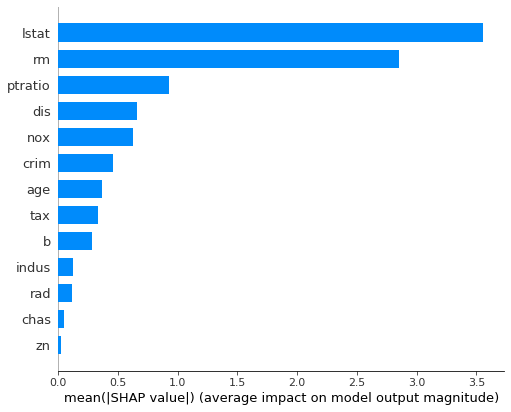

In [47]:
shap.summary_plot(shap_values,X_tr,plot_type='bar')

In [48]:
from xgboost import plot_importance as xgb_plot

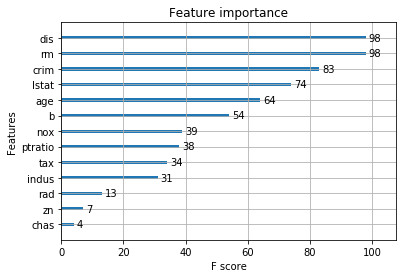

In [49]:
xgb_plot(xgb)

- **Feature Importances**는 Permutation 기법으로 해서 피처가 모델에 미치는 영향을 측정한다. -> 데이터 약간만 조작하면 되기에 계산 속도 빠르다.
- 그러나 서로 피처들이 의존적이면 결과 왜곡 우려가 있다. + 음의 영향력은 계산하지 않는다는 것이 특징 -> 실제 영향력보다 특정 피처의 가치가 높게 측정될 수 이싿.
- **SHAP**는 피처들이 서로 영향을 미칠 가능성을 고려.
- 피처 간의 의존성을 고려하고 음의 영향력을 계산할 수 있다. -> Feature Importance가 보장하지 못하는 넓은 범위의 함정을 피할 수 있다.